In [1]:

import sys
import os

print("python path", sys.executable)
print("python version", sys.version)

richrdf_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(richrdf_path)

try:
    import ROOT
except ImportError:
    import richrdf.experimental.setupROOT
    cvmfsversion="2024-10-03/x86_64-almalinux9-gcc14.2.0-opt"
    print(f"\nNo ROOT can be imported, trying to set up ROOT from cvmfs {cvmfsversion}\n")
    try:
        import richrdf.experimental
        richrdf.experimental.setupROOT.setupROOT(cvmfsversion=cvmfsversion)
        import ROOT
        print("\nROOT from cvmfs loaded\n")
    except ImportError:
        print("\nROOT not found, please set up ROOT\n")

import richrdf
print(richrdf.get_include_path())



python path /home/llr/ilc/liang/data/liang/software/anaconda3/envs/anaedm/bin/python
python version 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]

No ROOT can be imported, trying to set up ROOT from cvmfs 2024-10-03/x86_64-almalinux9-gcc14.2.0-opt

CVMFS version 2024-10-03/x86_64-almalinux9-gcc14.2.0-opt
LDDIR  ['/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/root/6.32.04-vms5ij/lib', '/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/edm4hep/0.99.1-zincmm/lib', '/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/podio/1.1-ur2cnz/lib']
ROOTDIR ['/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/root/6.32.04-vms5ij/lib']
Includes ['/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/edm4hep/0.99.1-zincmm/include', '/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/podio/1.1-ur2cnz/include']

In [2]:
if not os.path.exists("zh_mumu_REC.edm4hep.root"):
    # Download the sample file
    import urllib.request
    url = "https://raw.githubusercontent.com/lhprojects/edm4hep_sample/refs/heads/main/ILD/zh_mumu_REC.edm4hep.root"
    urllib.request.urlretrieve(url, "zh_mumu_REC.edm4hep.root")
    


In [3]:
import richrdf
ROOT.gInterpreter.AddIncludePath(richrdf.get_include_path())
ROOT.gInterpreter.Declare('''
#include <rrdf.h>
struct Ans1
{
    ROOT::VecOps::RVec<double> ph_E;
};

Ans1 analyzeEvent(rrdf::Event const &evt)
{
    Ans1 ans1;
    auto recs = evt.getReconstructedParticles("PandoraPFOs");

    for(int i : rrdf::range(recs.size())) {
        auto rec = recs[i];        
        if(rec.getType() == rrdf::PID::gamma) {
            ans1.ph_E.push_back(rec.getEnergy());
        }
    }
    return ans1;
}
''')


True

In [4]:
import richrdf
filename = "zh_mumu_REC.edm4hep.root"
df = richrdf.RichRDF("events", filename)
df = df.ReadEvent("event", ["PandoraPFOs"])
#df = df.ReadEvent("event")

df = df.Define("ans", "analyzeEvent(event)")
df = df.Define("ph_E", "ans.ph_E")
df = df.Define("notfIDS", "event.getNotFoundIDs()")

ph_E_H1D = df.Histo1D(("ph_E", "ph_E", 100, 0, 10), "ph_E") 
dfa = df.AsNumpy_(["notfIDS", "ph_E"]).GetValue()

print("Not found relationship IDs", dfa.notfIDS[0])

Not found relationship IDs { 1919347268, 2512145315, 450524680 }


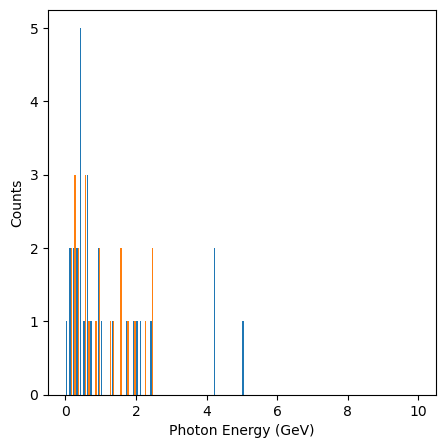

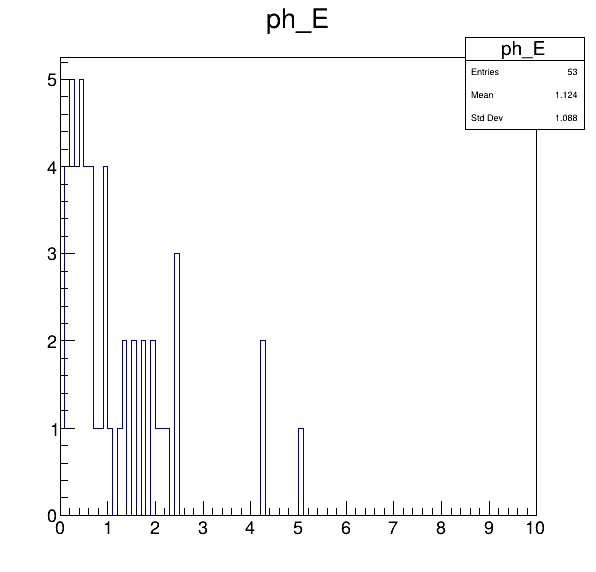

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from ROOT import TCanvas


c = TCanvas("c","Photon Energy", 600, 600)
ph_E_H1D.GetValue().DrawClone()
c.Draw()

dfa.ph_E_ = np.concatenate(dfa.ph_E)
plt.figure(figsize=(5, 5))
plt.hist(dfa.ph_E, bins=100, range=(0, 10))
plt.xlabel("Photon Energy (GeV)")
plt.ylabel("Counts")
plt.show()


